# Try to do regression using GPT-3

In [1]:
%reload_ext autoreload
%autoreload 2

In [31]:
import time

from fastcore.utils import save_pickle
from sklearn.model_selection import train_test_split

from gpt3forchem.api_wrappers import extract_prediction, fine_tune, query_gpt3, extract_regression_prediction
from gpt3forchem.data import get_polymer_data
from gpt3forchem.input import create_single_property_forward_prompts_regression

import matplotlib.pyplot as plt

plt.style.use(['science', 'nature'])

In [4]:
df = get_polymer_data()
df_train, df_test = train_test_split(df, train_size=200, random_state=42)


In [8]:
train_prompts = create_single_property_forward_prompts_regression(
    df_train, "deltaGmin", {"deltaGmin_cat": "adsorption energy"}
)

test_prompts = create_single_property_forward_prompts_regression(
    df_test, "deltaGmin", {"deltaGmin_cat": "adsorption energy"}
)


In [9]:
train_prompts

,prompt,completion
0,what is the deltaGmin of B-R-B-B-R-R-R-R-R-R-A...,-12.3@@@
1,what is the deltaGmin of R-A-R-B-R-W-W-B-W-R-B...,-9.8@@@
2,what is the deltaGmin of W-R-W-R-B-A-W-W-R-A-W...,-13.9@@@
3,what is the deltaGmin of W-R-W-B-W-A-A-A-R-W-B...,-9.0@@@
4,what is the deltaGmin of A-A-W-R-R-B-R-W-B-A-R...,-10.4@@@
...,...,...
195,what is the deltaGmin of R-R-B-B-W-R-W-B-A-B-B...,-16.1@@@
196,what is the deltaGmin of A-B-A-W-W-B-W-B-R-R-B...,-11.4@@@
197,what is the deltaGmin of R-W-R-B-B-R-B-B-R-R-B...,-8.3@@@
198,what is the deltaGmin of R-W-W-A-W-R-B-B-W-R-B...,-9.5@@@


In [10]:
train_size  = len(train_prompts)
test_size = len(test_prompts)

filename_base = time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())
train_filename = f"run_files/{filename_base}_train_prompts_polymers_regression_{train_size}.jsonl"
valid_filename = f"run_files/{filename_base}_valid_prompts_polymers_regression_{test_size}.jsonl"

train_prompts.to_json(train_filename, orient="records", lines=True)
test_prompts.to_json(valid_filename, orient="records", lines=True)


In [11]:
modelname = fine_tune(train_filename, valid_filename)

wandb: Currently logged in as: kjappelbaum. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.13.1
wandb: Run data is saved locally in /Users/kevinmaikjablonka/git/kjappelbaum/gpt3forchem/experiments/wandb/run-20220822_104328-ft-fARz0PHXfc4Dp43XiAh173PQ
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run ft-fARz0PHXfc4Dp43XiAh173PQ
wandb: ⭐️ View project at https://wandb.ai/kjappelbaum/GPT-3
wandb: 🚀 View run at https://wandb.ai/kjappelbaum/GPT-3/runs/ft-fARz0PHXfc4Dp43XiAh173PQ
wandb: Waiting for W&B process to finish... (success).
wandb:                                                                                
wandb: 
wandb: Run history:
wandb:             elapsed_examples ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:               elapsed_tokens ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                training_loss █▃▄▃▂▃▄▄▃▂▂▃▂▄▃▃▃▂▄▃▃▂▂▁▃▃▂▁▂▃▂▁▄▁▂▃▂▂▁▂
wandb:   training_sequence_accuracy ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁

🎉 wandb sync completed successfully


In [12]:
test_prompt_subset = test_prompts.iloc[:40]
completions = query_gpt3(modelname, test_prompt_subset)

In [13]:
completions

{'choices': [<OpenAIObject at 0x28a26f310> JSON: {
    "finish_reason": "length",
    "index": 0,
    "logprobs": null,
    "text": " -9.2@@@@@@@"
  },
  <OpenAIObject at 0x28a26f8b0> JSON: {
    "finish_reason": "length",
    "index": 1,
    "logprobs": null,
    "text": " -15.5@@@@@@@@"
  },
  <OpenAIObject at 0x28a26f950> JSON: {
    "finish_reason": "length",
    "index": 2,
    "logprobs": null,
    "text": " -7.2@@@@@@@"
  },
  <OpenAIObject at 0x28a26fcc0> JSON: {
    "finish_reason": "length",
    "index": 3,
    "logprobs": null,
    "text": " -9.2@@@@@@@"
  },
  <OpenAIObject at 0x28a26fd60> JSON: {
    "finish_reason": "length",
    "index": 4,
    "logprobs": null,
    "text": " -9.2@@@@@@@"
  },
  <OpenAIObject at 0x28a26fe00> JSON: {
    "finish_reason": "length",
    "index": 5,
    "logprobs": null,
    "text": " -13.5@@@@@@@@"
  },
  <OpenAIObject at 0x28a26fea0> JSON: {
    "finish_reason": "length",
    "index": 6,
    "logprobs": null,
    "text": " -6.2@@@@@@@"
  }

In [25]:
predictions = [extract_regression_prediction(completions, i) for i, completion in enumerate(completions["choices"])]

In [26]:
predictions

[-9.2,
 -15.5,
 -7.2,
 -9.2,
 -9.2,
 -13.5,
 -6.2,
 -11.2,
 -16.0,
 -13.0,
 -9.2,
 -11.2,
 -13.5,
 -6.2,
 -13.2,
 -6.2,
 -16.5,
 -9.2,
 -10.2,
 -15.0,
 -13.2,
 -9.2,
 -13.5,
 -6.5,
 -6.2,
 -16.0,
 -11.2,
 -6.2,
 -9.2,
 -6.2,
 -18.0,
 -10.2,
 -13.5,
 -16.0,
 -10.2,
 -13.5,
 -6.2,
 -13.5,
 -11.2,
 -6.5]

In [30]:
true = test_prompt_subset['completion'].apply(lambda x: float(x.split('@@')[0]))

Text(0, 0.5, 'predicted adsorption energy / kJ mol$^{-1}$')

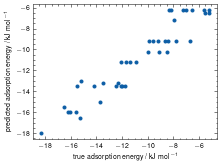

In [36]:
plt.scatter(true, predictions)
plt.xlabel('true adsorption energy / kJ mol$^{-1}$')
plt.ylabel('predicted adsorption energy / kJ mol$^{-1}$')